<a href="https://colab.research.google.com/github/tadiwamark/Video-Object-Detection/blob/main/Assignment2_R204445V.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importing modules
from keras.applications.inception_v3 import  InceptionV3
import keras
import os
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf


In [ ]:
#loading inceptionv3 model
model = InceptionV3()

96112376/96112376 [==============================] - 0s 0us/step


In [ ]:
#downloading data to use for retraining
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

68606236/68606236 [==============================] - 0s 0us/step
Found 2000 files belonging to 2 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


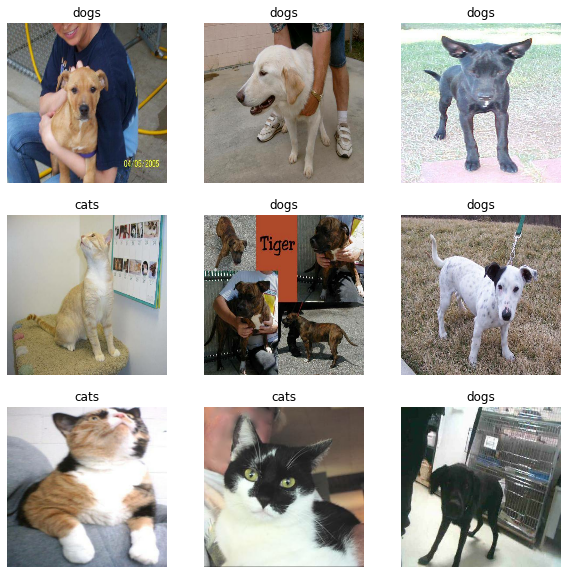

In [ ]:
#viewing the two classes
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

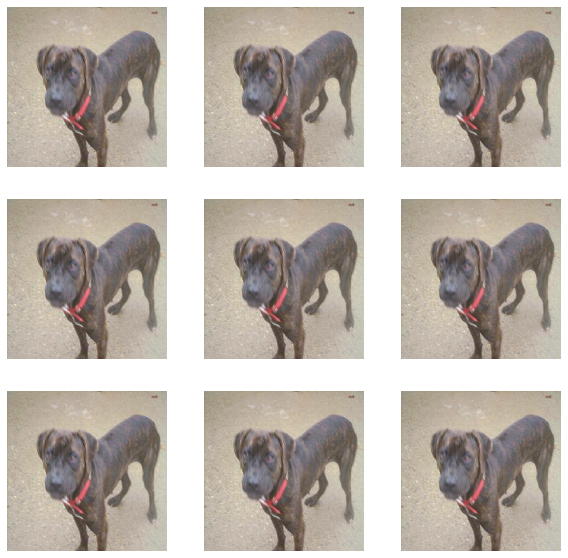

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
#preprocessing input
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

In [ ]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [ ]:
# Create the base model from the pre-trained model inceptionv3
IMG_SHAPE = IMG_SIZE + (3,)
base_model = InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 3, 3, 2048)


In [ ]:
base_model.trainable = False

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 33s 1s/step - loss: 0.8516 - accuracy: 0.5730


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.85
initial accuracy: 0.57


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 101s 2s/step - loss: 0.7551 - accuracy: 0.6515 - val_loss: 0.3844 - val_accuracy: 0.7970
Epoch 2/10
63/63 [==============================] - 94s 1s/step - loss: 0.5314 - accuracy: 0.7460 - val_loss: 0.2351 - val_accuracy: 0.9022
Epoch 3/10
63/63 [==============================] - 93s 1s/step - loss: 0.3971 - accuracy: 0.8250 - val_loss: 0.1860 - val_accuracy: 0.9282
Epoch 4/10
63/63 [==============================] - 96s 2s/step - loss: 0.3512 - accuracy: 0.8460 - val_loss: 0.1596 - val_accuracy: 0.9356
Epoch 5/10
63/63 [==============================] - 93s 1s/step - loss: 0.3283 - accuracy: 0.8535 - val_loss: 0.1413 - val_accuracy: 0.9431
Epoch 6/10
63/63 [==============================] - 93s 1s/step - loss: 0.2831 - accuracy: 0.8725 - val_loss: 0.1371 - val_accuracy: 0.9455
Epoch 7/10
63/63 [==============================] - 93s 1s/step - loss: 0.2756 - accuracy: 0.8760 - val_loss: 0.1282 - val_accuracy: 0.9517
Epoch 8/10
63/63 [=

In [ ]:
!pip install -q streamlit

     |████████████████████████████████| 9.2 MB 36.3 MB/s 
     |████████████████████████████████| 164 kB 68.4 MB/s 
     |████████████████████████████████| 237 kB 75.1 MB/s 
     |████████████████████████████████| 4.7 MB 57.9 MB/s 
     |████████████████████████████████| 78 kB 9.3 MB/s 
     |████████████████████████████████| 182 kB 80.0 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 51 kB 9.0 MB/s 


In [35]:
!pip -q install pyngrok

In [37]:
from pyngrok import ngrok

In [43]:
!ngrok authtoken 2HjaoecjmBAmaNFchv3HtQQgovu_2jgZkyqVN1XTxwTGnhi3X

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [39]:
model.save('./model.h5')

In [40]:
!pip install -q streamlit-option-menu

In [41]:
%%writefile app.py
import streamlit as st
import cv2
import tensorflow as tf 
import numpy as np
from keras.models import load_model
import sys
from streamlit_option_menu import option_menu

#Loading the Inception model
model= load_model('./model.h5',compile=(False))
st.markdown('<style>body{background-color:Blue;}</style>',unsafe_allow_html=True)



#Functions
def predict(frame, model):
    # Pre-process the image for model prediction
    img = cv2.resize(frame, (299, 299))
    img = img.astype(np.float32)
    img = np.expand_dims(img, axis=0)

    img /= 255.0

    # Predict with the Inceptionv3 model
    prediction = model.predict(img)

    # Convert the prediction into text
    pred_text = tf.keras.applications.inception_v3.decode_predictions(prediction, top=1)
    for (i, (imagenetID, label, prob)) in enumerate(pred_text[0]):
        label  = ("{}: {:.2f}%".format(label, prob * 100))

    st.markdown(label)


def predict2(frame, model):
    # Pre-process the image for model prediction
    img = cv2.resize(frame, (299, 299))
    img = img.astype(np.float32)
    img = np.expand_dims(img, axis=0)

    img /= 255.0

    # Predict with the Inceptionv3 model
    prediction = model.predict(img)

    # Convert the prediction into text
    pred_text = tf.keras.applications.inception_v3.decode_predictions(prediction, top=1)
    for (i, (imagenetID, label, prob)) in enumerate(pred_text[0]):
        pred_class = label
       

    return pred_class

def object_detection(search_key,frame, model):
    label = predict2(frame,model)
    label = label.lower()
    try:
        if label.find(search_key) > -1:
            sys.exit( st.image(frame, caption=label))
        else:
            pass  
           

    except:
        print('')
            
            
        



# Main App
def main():
    
    st.title("***Real Time Object Detection***")
    st.text("Machine Learning")

    
    choice = option_menu("Main Menu",["Home","Upload","About"],icons = ["house","cloud_upload","list-task"],menu_icon ="cast",default_index = 0,orientation = "horizontal")
    
    if choice == "Upload":
        st.subheader("Upload Your Video")

        video_file_path = st.file_uploader("accepting mp4,avi", type=["mp4", "avi"])

        if video_file_path is not None:
            path = video_file_path.name
            with open(path,mode='wb') as f: 
                f.write(video_file_path.read())         
                st.success("File Uploaded")
            cap = cv2.VideoCapture(path)
            frame_width = int(cap.get(3))
            frame_height = int(cap.get(4))

            fourcc = cv2.VideoWriter_fourcc(*'XVID')
            output = cv2.VideoWriter('output.mp4', fourcc, 20.0, (frame_width, frame_height))
            
            if st.button("Detect Objects"):
                
                # Start the video prediction loop
                while cap.isOpened():
                    ret, frame = cap.read()
    
                    if not ret:
                        break
    
                    
                    predict(frame, model)
    
                    # Display the resulting frame
                    
                cap.release()
                output.release()
                cv2.destroyAllWindows()
                
            key = st.text_input('Search key')
            key = key.lower()
            
            if key is not None:
            
                if st.button("Search for an object"):
                    
                    
                    # Start the video prediction loop
                    while cap.isOpened():
                        ret, frame = cap.read()
        
                        if not ret:
                            break
        
                        # Perform object detection
                        object_detection(key,frame, model)
                        
                    cap.release()
                    output.release()
                    cv2.destroyAllWindows()

    elif choice == "Home":
        st.subheader("Detect Objects In Video")
        st.image("./car.jpg")
        
       

if __name__ == '__main__':
    main()

Overwriting app.py


In [51]:
address = ngrok.connect(port=8501)

PyngrokNgrokHTTPError: ignored

In [49]:
address

<NgrokTunnel: "http://f602-34-145-165-35.ngrok.io" -> "http://localhost:80">